参考链接:https://curiousily.com/posts/practical-guide-to-handling-imbalanced-datasets/

数据：https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data?select=train.csv

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [11]:
import seaborn as sns

In [3]:
df = pd.read_csv('C:\\Users\yanghuilin\Desktop\charge\data\数据不平衡\\train.csv')
df.shape

(595212, 59)

D:\Users\yanghuilin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


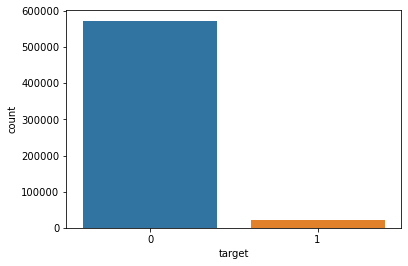

In [4]:
sns.countplot(df.target);
# 提交索赔和不提交索赔的人比例很不平衡

特征中的-1均为缺失值，首先需要处理缺失值

In [5]:
row_count = df.shape[0]
for c in df.columns:
    m_count = df[df[c]==-1][c].count()
    if m_count>0:
        print(f'{c} - {m_count} ({round(m_count/row_count,3)}) rows missing')

ps_ind_02_cat - 216 (0.0) rows missing
ps_ind_04_cat - 83 (0.0) rows missing
ps_ind_05_cat - 5809 (0.01) rows missing
ps_reg_03 - 107772 (0.181) rows missing
ps_car_01_cat - 107 (0.0) rows missing
ps_car_02_cat - 5 (0.0) rows missing
ps_car_03_cat - 411231 (0.691) rows missing
ps_car_05_cat - 266551 (0.448) rows missing
ps_car_07_cat - 11489 (0.019) rows missing
ps_car_09_cat - 569 (0.001) rows missing
ps_car_11 - 5 (0.0) rows missing
ps_car_12 - 1 (0.0) rows missing
ps_car_14 - 42620 (0.072) rows missing


In [6]:
# 有三列缺失值过多直接删除
df.drop(['ps_reg_03','ps_car_05_cat','ps_car_05_cat'],inplace=True,axis=1)

In [7]:
from sklearn.impute import SimpleImputer

cat_columns = ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat',
  'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_07_cat',
  'ps_car_09_cat']
num_columns = ['ps_car_11', 'ps_car_12', 'ps_car_14']
mean_imp = SimpleImputer(missing_values=-1,strategy='mean')
cat_imp = SimpleImputer(missing_values=-1,strategy='most_frequent')
for c in cat_columns:
    df[c] = cat_imp.fit_transform(df[[c]]).ravel()
for c in num_columns:
    df[c] = mean_imp.fit_transform(df[[c]]).ravel()

In [8]:
# 哑变量设置
df = pd.get_dummies(df,columns=cat_columns)

In [9]:
from sklearn.model_selection import train_test_split
labels = df.columns[2:]
X = df[labels]
y = df['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.05,random_state=RANDOM_SEED)

In [10]:
def build_model(train_data,metrics=['accuracy']):
    model = keras.Sequential([keras.layers.Dense(units=36,activation='relu',input_shape=(train_data.shape[-1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(units=1,activation='sigmoid'),])
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics)
    return model

In [11]:
# 通常batch_size = 32 比较好，但是犹豫数据极度不平衡，需要尽可能大使每个size都有提交索赔用户
BATCH_SIZE = 2048
model = build_model(X_train)
history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs = 20,validation_split=0.05,shuffle=True,verbose=0)

In [12]:
model.evaluate(X_test,y_test,batch_size=BATCH_SIZE)

15/15 [==============================] - 0s 2ms/step - loss: 0.1565 - accuracy: 0.9624


[0.15654899179935455, 0.9623668789863586]

由于不平衡的数据，不做任何处理的预测不提交索赔也有很高的精确率,几乎一样

In [13]:
from sklearn.metrics import accuracy_score
def awesome_model_predict(features):
    return np.full((features.shape[0],),0)
y_pred = awesome_model_predict(X_test)
accuracy_score(y_pred,y_test)

0.9623332549309499

我们只是用了错误的度量标准来评估我们的模型。这是一个众所周知的问题。准确性悖论表明，当数据集不平衡时，准确性可能不是正确的度量标准。

In [18]:
 METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]



### 未索赔远小于索赔，可以通过赋予权重来平衡

In [19]:
no_claim_count,claim_count = np.bincount(df.target)
total_count = len(df.target)

weight_no_claim = (1/no_claim_count)*total_count/2.
weight_claim = (1/claim_count)*total_count/2.

class_weights = {0:weight_no_claim,1:weight_claim}

In [20]:
model = build_model(X_train,metrics = METRICS)
history = model.fit(X_train,y_train,batch_size = BATCH_SIZE,epochs=20,validation_split=0.05,shuffle=True,verbose=0,class_weight=class_weights)

In [25]:
model.evaluate(X_test,y_test,batch_size=BATCH_SIZE)


15/15 [==============================] - 0s 6ms/step - loss: 0.6991 - tp: 717.0000 - fp: 12817.0000 - tn: 15823.0000 - fn: 404.0000 - accuracy: 0.5558 - precision: 0.0530 - recall: 0.6396 - auc: 0.6317


[0.6990980505943298,
 717.0,
 12817.0,
 15823.0,
 404.0,
 0.55576092004776,
 0.05297768488526344,
 0.6396074891090393,
 0.6317063570022583]

### 方法三，重采样技术
1. 过度采样，重复采样提交索赔
2. 欠采样，随机选取部分未提交索赔
3. 生成合成数据

In [27]:
X = pd.concat([X_train,y_train],axis=1)
no_claim = X[X.target==0]
claim = X[X.target==1]

In [28]:
# oversample
from sklearn.utils import resample

claim_upsampled = resample(claim,replace=True,n_samples=len(no_claim),random_state=RANDOM_SEED)

In [29]:
# undersample
no_claim_downsampled = resample(no_claim,replace=False,n_samples=len(claim),random_state=RANDOM_SEED)

In [32]:
# # generating synthetic samples
# from imblearn.over_sampling import SMOTE

# sm = SMOTE(random_state=RANDOM_SEED,ratio=1.0)
# X_train,y_train = sm.fit_sample(X_train,y_train)